# Classifying Identifiable People Using Image Classification
Identify whether individuals in an image are "identifiable" or "unidentifiable". Images are considered "identifiable" if they clearly show an individual's face with no obstructions (mask, sunglasses, etc.). An applicaton of this project may be for companies that need to keep track of everyone visiting their locations.

## Building a Classification Model
### Step 1: Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

### Step 2: Load the Data

In [2]:
labels = ['identifiable', 'unidentifiable']
img_size = 224

def get_data(data_dir):
    """Return a numpy array

    Numpy array containing train or testing set data values. Read the images from 
    data_dir in the RGB format and resize the images to the desired width and height.
    """
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label) # 0: identifiable, 1: unidentifiable
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [3]:
# Fetch the train and validation data.
train = get_data('images dataset/Training Set')
val = get_data('images dataset/Testing Set')

### Step 3: Visualize the data

<AxesSubplot:ylabel='count'>

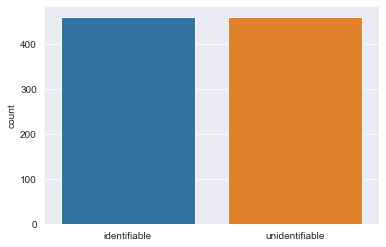

In [4]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("identifiable")
    else:
        l.append("unidentifiable")
sns.set_style('darkgrid')
sns.countplot(x=l)

Text(0.5, 1.0, 'identifiable')

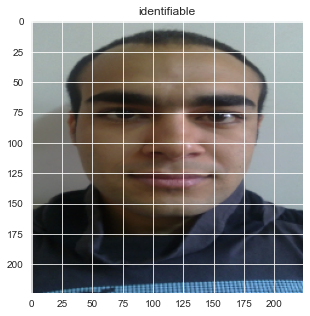

In [5]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'unidentifiable')

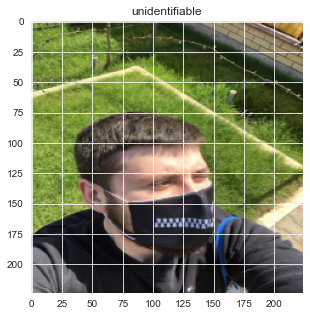

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

### Step 4: Data Preprocessing and Augmentation

In [7]:
# Preprocess the data
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [8]:
# Augment the data
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

### Step 5: Define the Model

In [9]:
# Define a simple CNN with 3 Convolutional layers followed by max-pooling layers. 
#   A dropout layer is added after the 3rd maxpool operation to avoid overfitting.
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0

In [10]:
# Compile the model using the Adam optimizer.
#   SparseCategoricalCrossentropy is the loss function.
#   Use a lower learning rate of 0.000001 for a smoother curve.
opt = Adam(lr=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [11]:
# epochs represent the number of times the model goes through the training set.
#   The model can be updated multiple times during one epoch.
#   Train the model for 500 epochs because the learning rate is so small.
#      500 epochs will produce a runtime of nearly 4 hours on a local machine.
numEpochs = 500
history = model.fit(x_train,y_train,epochs = numEpochs , validation_data = (x_val, y_val))

Epoch 1/500
29/29 [==============================] - 21s 718ms/step - loss: 0.6923 - accuracy: 0.5305 - val_loss: 0.6968 - val_accuracy: 0.4911
Epoch 2/500
29/29 [==============================] - 19s 664ms/step - loss: 0.6917 - accuracy: 0.5286 - val_loss: 0.6955 - val_accuracy: 0.4937
Epoch 3/500
29/29 [==============================] - 19s 669ms/step - loss: 0.7030 - accuracy: 0.4617 - val_loss: 0.6940 - val_accuracy: 0.5165
Epoch 4/500
29/29 [==============================] - 19s 661ms/step - loss: 0.6991 - accuracy: 0.4900 - val_loss: 0.6922 - val_accuracy: 0.5063
Epoch 5/500
29/29 [==============================] - 19s 661ms/step - loss: 0.7032 - accuracy: 0.4928 - val_loss: 0.6908 - val_accuracy: 0.5342
Epoch 6/500
29/29 [==============================] - 19s 660ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6893 - val_accuracy: 0.5342
Epoch 7/500
29/29 [==============================] - 19s 661ms/step - loss: 0.6955 - accuracy: 0.5097 - val_loss: 0.6879 - val_accuracy:

29/29 [==============================] - 19s 664ms/step - loss: 0.5756 - accuracy: 0.7463 - val_loss: 0.5981 - val_accuracy: 0.6861
Epoch 58/500
29/29 [==============================] - 19s 664ms/step - loss: 0.5738 - accuracy: 0.7489 - val_loss: 0.5967 - val_accuracy: 0.6861
Epoch 59/500
29/29 [==============================] - 19s 664ms/step - loss: 0.5684 - accuracy: 0.7323 - val_loss: 0.5947 - val_accuracy: 0.6835
Epoch 60/500
29/29 [==============================] - 19s 664ms/step - loss: 0.5803 - accuracy: 0.7346 - val_loss: 0.5925 - val_accuracy: 0.7114
Epoch 61/500
29/29 [==============================] - 19s 664ms/step - loss: 0.5815 - accuracy: 0.7035 - val_loss: 0.5902 - val_accuracy: 0.6962
Epoch 62/500
29/29 [==============================] - 19s 666ms/step - loss: 0.5702 - accuracy: 0.7288 - val_loss: 0.5894 - val_accuracy: 0.7013
Epoch 63/500
29/29 [==============================] - 19s 664ms/step - loss: 0.5688 - accuracy: 0.7294 - val_loss: 0.5868 - val_accuracy: 0.719

29/29 [==============================] - 19s 665ms/step - loss: 0.4731 - accuracy: 0.8147 - val_loss: 0.5114 - val_accuracy: 0.7646
Epoch 114/500
29/29 [==============================] - 19s 667ms/step - loss: 0.4705 - accuracy: 0.8229 - val_loss: 0.5101 - val_accuracy: 0.7772
Epoch 115/500
29/29 [==============================] - 19s 669ms/step - loss: 0.4662 - accuracy: 0.8048 - val_loss: 0.5093 - val_accuracy: 0.7696
Epoch 116/500
29/29 [==============================] - 19s 665ms/step - loss: 0.4577 - accuracy: 0.8041 - val_loss: 0.5076 - val_accuracy: 0.7747
Epoch 117/500
29/29 [==============================] - 19s 666ms/step - loss: 0.4544 - accuracy: 0.8250 - val_loss: 0.5062 - val_accuracy: 0.7772
Epoch 118/500
29/29 [==============================] - 19s 667ms/step - loss: 0.4529 - accuracy: 0.8123 - val_loss: 0.5051 - val_accuracy: 0.7747
Epoch 119/500
29/29 [==============================] - 19s 665ms/step - loss: 0.4576 - accuracy: 0.8128 - val_loss: 0.5053 - val_accuracy:

29/29 [==============================] - 19s 669ms/step - loss: 0.3705 - accuracy: 0.8618 - val_loss: 0.4545 - val_accuracy: 0.8076
Epoch 170/500
29/29 [==============================] - 20s 677ms/step - loss: 0.3716 - accuracy: 0.8670 - val_loss: 0.4542 - val_accuracy: 0.8101
Epoch 171/500
29/29 [==============================] - 20s 675ms/step - loss: 0.3936 - accuracy: 0.8473 - val_loss: 0.4542 - val_accuracy: 0.7924
Epoch 172/500
29/29 [==============================] - 19s 672ms/step - loss: 0.3933 - accuracy: 0.8329 - val_loss: 0.4530 - val_accuracy: 0.7949
Epoch 173/500
29/29 [==============================] - 20s 676ms/step - loss: 0.3848 - accuracy: 0.8580 - val_loss: 0.4520 - val_accuracy: 0.8101
Epoch 174/500
29/29 [==============================] - 19s 665ms/step - loss: 0.3616 - accuracy: 0.8707 - val_loss: 0.4506 - val_accuracy: 0.8025
Epoch 175/500
29/29 [==============================] - 19s 667ms/step - loss: 0.3881 - accuracy: 0.8498 - val_loss: 0.4513 - val_accuracy:

29/29 [==============================] - 20s 687ms/step - loss: 0.3456 - accuracy: 0.8628 - val_loss: 0.4186 - val_accuracy: 0.8203
Epoch 226/500
29/29 [==============================] - 20s 687ms/step - loss: 0.3368 - accuracy: 0.8665 - val_loss: 0.4227 - val_accuracy: 0.8101
Epoch 227/500
29/29 [==============================] - 20s 687ms/step - loss: 0.3467 - accuracy: 0.8697 - val_loss: 0.4181 - val_accuracy: 0.8076
Epoch 228/500
29/29 [==============================] - 20s 690ms/step - loss: 0.3555 - accuracy: 0.8532 - val_loss: 0.4185 - val_accuracy: 0.8203
Epoch 229/500
29/29 [==============================] - 20s 688ms/step - loss: 0.3276 - accuracy: 0.8696 - val_loss: 0.4169 - val_accuracy: 0.8203
Epoch 230/500
29/29 [==============================] - 20s 688ms/step - loss: 0.3239 - accuracy: 0.8818 - val_loss: 0.4163 - val_accuracy: 0.8177
Epoch 231/500
29/29 [==============================] - 20s 688ms/step - loss: 0.3369 - accuracy: 0.8820 - val_loss: 0.4167 - val_accuracy:

29/29 [==============================] - 19s 668ms/step - loss: 0.2907 - accuracy: 0.8968 - val_loss: 0.4004 - val_accuracy: 0.8152
Epoch 282/500
29/29 [==============================] - 19s 668ms/step - loss: 0.2983 - accuracy: 0.8911 - val_loss: 0.4042 - val_accuracy: 0.8203
Epoch 283/500
29/29 [==============================] - 19s 667ms/step - loss: 0.2794 - accuracy: 0.8990 - val_loss: 0.3999 - val_accuracy: 0.8203
Epoch 284/500
29/29 [==============================] - 19s 669ms/step - loss: 0.2957 - accuracy: 0.9029 - val_loss: 0.4003 - val_accuracy: 0.8203
Epoch 285/500
29/29 [==============================] - 19s 668ms/step - loss: 0.3185 - accuracy: 0.8824 - val_loss: 0.4011 - val_accuracy: 0.8203
Epoch 286/500
29/29 [==============================] - 19s 669ms/step - loss: 0.2865 - accuracy: 0.9055 - val_loss: 0.4036 - val_accuracy: 0.8203
Epoch 287/500
29/29 [==============================] - 19s 668ms/step - loss: 0.2862 - accuracy: 0.8996 - val_loss: 0.3993 - val_accuracy:

29/29 [==============================] - 19s 671ms/step - loss: 0.2772 - accuracy: 0.9003 - val_loss: 0.3941 - val_accuracy: 0.8203
Epoch 338/500
29/29 [==============================] - 19s 669ms/step - loss: 0.2749 - accuracy: 0.8988 - val_loss: 0.3934 - val_accuracy: 0.8228
Epoch 339/500
29/29 [==============================] - 19s 669ms/step - loss: 0.2811 - accuracy: 0.9122 - val_loss: 0.3947 - val_accuracy: 0.8228
Epoch 340/500
29/29 [==============================] - 19s 668ms/step - loss: 0.2620 - accuracy: 0.9127 - val_loss: 0.3936 - val_accuracy: 0.8203
Epoch 341/500
29/29 [==============================] - 19s 668ms/step - loss: 0.2486 - accuracy: 0.9140 - val_loss: 0.3934 - val_accuracy: 0.8228
Epoch 342/500
29/29 [==============================] - 19s 670ms/step - loss: 0.2621 - accuracy: 0.9091 - val_loss: 0.3938 - val_accuracy: 0.8203
Epoch 343/500
29/29 [==============================] - 19s 674ms/step - loss: 0.2518 - accuracy: 0.9145 - val_loss: 0.3920 - val_accuracy:

29/29 [==============================] - 19s 672ms/step - loss: 0.2234 - accuracy: 0.9348 - val_loss: 0.3901 - val_accuracy: 0.8304
Epoch 394/500
29/29 [==============================] - 19s 666ms/step - loss: 0.2330 - accuracy: 0.9185 - val_loss: 0.3919 - val_accuracy: 0.8228
Epoch 395/500
29/29 [==============================] - 19s 668ms/step - loss: 0.2432 - accuracy: 0.9220 - val_loss: 0.3898 - val_accuracy: 0.8304
Epoch 396/500
29/29 [==============================] - 19s 675ms/step - loss: 0.2373 - accuracy: 0.9199 - val_loss: 0.3902 - val_accuracy: 0.8304
Epoch 397/500
29/29 [==============================] - 19s 671ms/step - loss: 0.2247 - accuracy: 0.9302 - val_loss: 0.3952 - val_accuracy: 0.8253
Epoch 398/500
29/29 [==============================] - 19s 668ms/step - loss: 0.2534 - accuracy: 0.9165 - val_loss: 0.3903 - val_accuracy: 0.8304
Epoch 399/500
29/29 [==============================] - 19s 668ms/step - loss: 0.2486 - accuracy: 0.9127 - val_loss: 0.3903 - val_accuracy:

29/29 [==============================] - 19s 672ms/step - loss: 0.2077 - accuracy: 0.9374 - val_loss: 0.3920 - val_accuracy: 0.8304
Epoch 450/500
29/29 [==============================] - 19s 667ms/step - loss: 0.2176 - accuracy: 0.9240 - val_loss: 0.3910 - val_accuracy: 0.8354
Epoch 451/500
29/29 [==============================] - 19s 669ms/step - loss: 0.2049 - accuracy: 0.9387 - val_loss: 0.3959 - val_accuracy: 0.8253
Epoch 452/500
29/29 [==============================] - 20s 678ms/step - loss: 0.1985 - accuracy: 0.9493 - val_loss: 0.3906 - val_accuracy: 0.8354
Epoch 453/500
29/29 [==============================] - 19s 672ms/step - loss: 0.1972 - accuracy: 0.9467 - val_loss: 0.3923 - val_accuracy: 0.8354
Epoch 454/500
29/29 [==============================] - 19s 671ms/step - loss: 0.2177 - accuracy: 0.9299 - val_loss: 0.3915 - val_accuracy: 0.8354
Epoch 455/500
29/29 [==============================] - 19s 671ms/step - loss: 0.2071 - accuracy: 0.9359 - val_loss: 0.3943 - val_accuracy:

### Step 6: Evaluate the Model

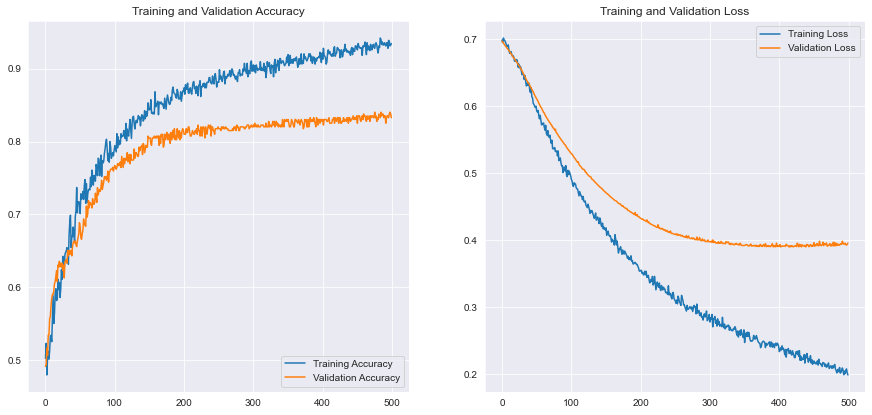

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range is 5 beacause the previous step used 5 epochs
epochs_range = range(numEpochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot( epochs_range, acc, label='Training Accuracy')
plt.plot( epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
# predictions = model.predict_classes(x_val)
# above line is soon to be deprecated, is replaced with line below
predictions = np.argmax(model.predict(x_val), axis=-1)
predictions = predictions.reshape(1,-1)[0]

print(classification_report(y_val, predictions, target_names = ['Identifiable (Class 0)','Unidentifiable (Class 1)']))

                          precision    recall  f1-score   support

  Identifiable (Class 0)       0.85      0.80      0.83       197
Unidentifiable (Class 1)       0.81      0.86      0.84       198

                accuracy                           0.83       395
               macro avg       0.83      0.83      0.83       395
            weighted avg       0.83      0.83      0.83       395



## Implementing a Pre-Trained Model
### Step 1: Import the Model

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top = False,
                                               weights = "imagenet")

In [15]:
base_model.trainable = False

In [16]:
# Line Changed: tf.keras.layers.Dense(2, activation="softmax")
#   Adds a final dense layer with 2 neurons and softmax activation.
#   This led to a ValueError when calling model.fit(...):
#      ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1))
#   Possible solution involves changing the dimensions of x_train, y_train, x_val, and/or y_val.
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(1, activation="softmax")                                     
                                ])

In [17]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train,y_train,epochs = numEpochs , validation_data = (x_val, y_val))

Epoch 1/500
29/29 [==============================] - 22s 666ms/step - loss: 0.6421 - accuracy: 0.4883 - val_loss: 0.6345 - val_accuracy: 0.5013
Epoch 2/500
29/29 [==============================] - 18s 629ms/step - loss: 0.6274 - accuracy: 0.5068 - val_loss: 0.6249 - val_accuracy: 0.5013
Epoch 3/500
29/29 [==============================] - 18s 629ms/step - loss: 0.6482 - accuracy: 0.5178 - val_loss: 0.6155 - val_accuracy: 0.5013
Epoch 4/500
29/29 [==============================] - 18s 631ms/step - loss: 0.6141 - accuracy: 0.4827 - val_loss: 0.6061 - val_accuracy: 0.5013
Epoch 5/500
29/29 [==============================] - 18s 629ms/step - loss: 0.6385 - accuracy: 0.4908 - val_loss: 0.5970 - val_accuracy: 0.5013
Epoch 6/500
29/29 [==============================] - 18s 631ms/step - loss: 0.6018 - accuracy: 0.5254 - val_loss: 0.5882 - val_accuracy: 0.5013
Epoch 7/500
29/29 [==============================] - 18s 629ms/step - loss: 0.5861 - accuracy: 0.4972 - val_loss: 0.5797 - val_accuracy:

29/29 [==============================] - 18s 631ms/step - loss: 0.3116 - accuracy: 0.4979 - val_loss: 0.3110 - val_accuracy: 0.5013
Epoch 58/500
29/29 [==============================] - 18s 630ms/step - loss: 0.3098 - accuracy: 0.4903 - val_loss: 0.3077 - val_accuracy: 0.5013
Epoch 59/500
29/29 [==============================] - 18s 632ms/step - loss: 0.2993 - accuracy: 0.5006 - val_loss: 0.3046 - val_accuracy: 0.5013
Epoch 60/500
29/29 [==============================] - 18s 630ms/step - loss: 0.2953 - accuracy: 0.5081 - val_loss: 0.3015 - val_accuracy: 0.5013
Epoch 61/500
29/29 [==============================] - 18s 630ms/step - loss: 0.3110 - accuracy: 0.4852 - val_loss: 0.2985 - val_accuracy: 0.5013
Epoch 62/500
29/29 [==============================] - 18s 630ms/step - loss: 0.2982 - accuracy: 0.4973 - val_loss: 0.2955 - val_accuracy: 0.5013
Epoch 63/500
29/29 [==============================] - 18s 630ms/step - loss: 0.3009 - accuracy: 0.5084 - val_loss: 0.2925 - val_accuracy: 0.501

29/29 [==============================] - 18s 630ms/step - loss: 0.1822 - accuracy: 0.5244 - val_loss: 0.1917 - val_accuracy: 0.5013
Epoch 114/500
29/29 [==============================] - 18s 630ms/step - loss: 0.1995 - accuracy: 0.5049 - val_loss: 0.1904 - val_accuracy: 0.5013
Epoch 115/500
29/29 [==============================] - 18s 630ms/step - loss: 0.1829 - accuracy: 0.4908 - val_loss: 0.1890 - val_accuracy: 0.5013
Epoch 116/500
29/29 [==============================] - 18s 630ms/step - loss: 0.1738 - accuracy: 0.5150 - val_loss: 0.1878 - val_accuracy: 0.5013
Epoch 117/500
29/29 [==============================] - 18s 629ms/step - loss: 0.1849 - accuracy: 0.5041 - val_loss: 0.1865 - val_accuracy: 0.5013
Epoch 118/500
29/29 [==============================] - 18s 632ms/step - loss: 0.1835 - accuracy: 0.4877 - val_loss: 0.1852 - val_accuracy: 0.5013
Epoch 119/500
29/29 [==============================] - 18s 632ms/step - loss: 0.1725 - accuracy: 0.5049 - val_loss: 0.1840 - val_accuracy:

29/29 [==============================] - 22s 756ms/step - loss: 0.1274 - accuracy: 0.4997 - val_loss: 0.1374 - val_accuracy: 0.5013
Epoch 170/500
29/29 [==============================] - 21s 743ms/step - loss: 0.1247 - accuracy: 0.5002 - val_loss: 0.1367 - val_accuracy: 0.5013
Epoch 171/500
29/29 [==============================] - 21s 738ms/step - loss: 0.1228 - accuracy: 0.5016 - val_loss: 0.1360 - val_accuracy: 0.5013
Epoch 172/500
29/29 [==============================] - 21s 743ms/step - loss: 0.1287 - accuracy: 0.5058 - val_loss: 0.1354 - val_accuracy: 0.5013
Epoch 173/500
29/29 [==============================] - 19s 662ms/step - loss: 0.1262 - accuracy: 0.5012 - val_loss: 0.1347 - val_accuracy: 0.5013
Epoch 174/500
29/29 [==============================] - 18s 632ms/step - loss: 0.1222 - accuracy: 0.5109 - val_loss: 0.1341 - val_accuracy: 0.5013
Epoch 175/500
29/29 [==============================] - 18s 630ms/step - loss: 0.1218 - accuracy: 0.4976 - val_loss: 0.1334 - val_accuracy:

29/29 [==============================] - 18s 629ms/step - loss: 0.0950 - accuracy: 0.4936 - val_loss: 0.1090 - val_accuracy: 0.5013
Epoch 226/500
29/29 [==============================] - 18s 631ms/step - loss: 0.0936 - accuracy: 0.4802 - val_loss: 0.1086 - val_accuracy: 0.5013
Epoch 227/500
29/29 [==============================] - 18s 631ms/step - loss: 0.0933 - accuracy: 0.4968 - val_loss: 0.1082 - val_accuracy: 0.5013
Epoch 228/500
29/29 [==============================] - 18s 629ms/step - loss: 0.0944 - accuracy: 0.5106 - val_loss: 0.1079 - val_accuracy: 0.5013
Epoch 229/500
29/29 [==============================] - 18s 629ms/step - loss: 0.0952 - accuracy: 0.4736 - val_loss: 0.1075 - val_accuracy: 0.5013
Epoch 230/500
29/29 [==============================] - 18s 631ms/step - loss: 0.0889 - accuracy: 0.5110 - val_loss: 0.1072 - val_accuracy: 0.5013
Epoch 231/500
29/29 [==============================] - 18s 629ms/step - loss: 0.1192 - accuracy: 0.4860 - val_loss: 0.1068 - val_accuracy:

29/29 [==============================] - 18s 630ms/step - loss: 0.0798 - accuracy: 0.4923 - val_loss: 0.0928 - val_accuracy: 0.5013
Epoch 282/500
29/29 [==============================] - 18s 632ms/step - loss: 0.0657 - accuracy: 0.5089 - val_loss: 0.0926 - val_accuracy: 0.5013
Epoch 283/500
29/29 [==============================] - 18s 632ms/step - loss: 0.0828 - accuracy: 0.4954 - val_loss: 0.0924 - val_accuracy: 0.5013
Epoch 284/500
29/29 [==============================] - 18s 631ms/step - loss: 0.0723 - accuracy: 0.5171 - val_loss: 0.0922 - val_accuracy: 0.5013
Epoch 285/500
29/29 [==============================] - 18s 632ms/step - loss: 0.0807 - accuracy: 0.5129 - val_loss: 0.0920 - val_accuracy: 0.5013
Epoch 286/500
29/29 [==============================] - 18s 632ms/step - loss: 0.0739 - accuracy: 0.5033 - val_loss: 0.0918 - val_accuracy: 0.5013
Epoch 287/500
29/29 [==============================] - 18s 633ms/step - loss: 0.0996 - accuracy: 0.4951 - val_loss: 0.0916 - val_accuracy:

29/29 [==============================] - 18s 631ms/step - loss: 0.0667 - accuracy: 0.5145 - val_loss: 0.0829 - val_accuracy: 0.5013
Epoch 338/500
29/29 [==============================] - 18s 630ms/step - loss: 0.0592 - accuracy: 0.4993 - val_loss: 0.0828 - val_accuracy: 0.5013
Epoch 339/500
29/29 [==============================] - 18s 632ms/step - loss: 0.0712 - accuracy: 0.4939 - val_loss: 0.0826 - val_accuracy: 0.5013
Epoch 340/500
29/29 [==============================] - 18s 631ms/step - loss: 0.0812 - accuracy: 0.5186 - val_loss: 0.0825 - val_accuracy: 0.5013
Epoch 341/500
29/29 [==============================] - 18s 630ms/step - loss: 0.0589 - accuracy: 0.5087 - val_loss: 0.0824 - val_accuracy: 0.5013
Epoch 342/500
29/29 [==============================] - 18s 632ms/step - loss: 0.0701 - accuracy: 0.4825 - val_loss: 0.0823 - val_accuracy: 0.5013
Epoch 343/500
29/29 [==============================] - 18s 637ms/step - loss: 0.0706 - accuracy: 0.4830 - val_loss: 0.0821 - val_accuracy:

29/29 [==============================] - 18s 630ms/step - loss: 0.0628 - accuracy: 0.4959 - val_loss: 0.0765 - val_accuracy: 0.5013
Epoch 394/500
29/29 [==============================] - 18s 630ms/step - loss: 0.0556 - accuracy: 0.5052 - val_loss: 0.0764 - val_accuracy: 0.5013
Epoch 395/500
29/29 [==============================] - 18s 632ms/step - loss: 0.0767 - accuracy: 0.5108 - val_loss: 0.0763 - val_accuracy: 0.5013
Epoch 396/500
29/29 [==============================] - 18s 630ms/step - loss: 0.0763 - accuracy: 0.4806 - val_loss: 0.0762 - val_accuracy: 0.5013
Epoch 397/500
29/29 [==============================] - 18s 630ms/step - loss: 0.0744 - accuracy: 0.5024 - val_loss: 0.0761 - val_accuracy: 0.5013
Epoch 398/500
29/29 [==============================] - 18s 630ms/step - loss: 0.0684 - accuracy: 0.4954 - val_loss: 0.0760 - val_accuracy: 0.5013
Epoch 399/500
29/29 [==============================] - 18s 630ms/step - loss: 0.0786 - accuracy: 0.4789 - val_loss: 0.0759 - val_accuracy:

29/29 [==============================] - 18s 630ms/step - loss: 0.0685 - accuracy: 0.4979 - val_loss: 0.0719 - val_accuracy: 0.5013
Epoch 450/500
29/29 [==============================] - 18s 631ms/step - loss: 0.0710 - accuracy: 0.4910 - val_loss: 0.0718 - val_accuracy: 0.5013
Epoch 451/500
29/29 [==============================] - 18s 631ms/step - loss: 0.0482 - accuracy: 0.4924 - val_loss: 0.0717 - val_accuracy: 0.5013
Epoch 452/500
29/29 [==============================] - 18s 636ms/step - loss: 0.0533 - accuracy: 0.4836 - val_loss: 0.0717 - val_accuracy: 0.5013
Epoch 453/500
29/29 [==============================] - 18s 640ms/step - loss: 0.0464 - accuracy: 0.5197 - val_loss: 0.0716 - val_accuracy: 0.5013
Epoch 454/500
29/29 [==============================] - 18s 631ms/step - loss: 0.0468 - accuracy: 0.4943 - val_loss: 0.0715 - val_accuracy: 0.5013
Epoch 455/500
29/29 [==============================] - 18s 631ms/step - loss: 0.0441 - accuracy: 0.4944 - val_loss: 0.0714 - val_accuracy:

### Step 2: Evaluating the result

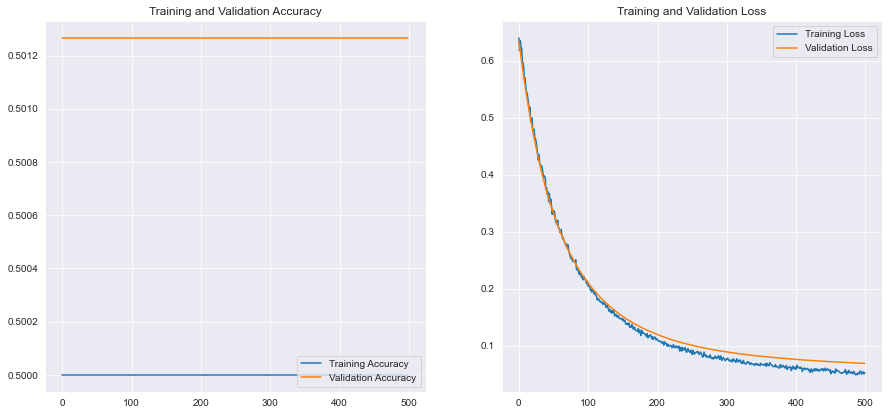

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(numEpochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
predictions = np.argmax(model.predict(x_val), axis=-1)
predictions = predictions.reshape(1,-1)[0]

print(classification_report(y_val, predictions, target_names = ['Identifiable (Class 0)','Unidentifiable (Class 1)']))

                          precision    recall  f1-score   support

  Identifiable (Class 0)       0.50      1.00      0.67       197
Unidentifiable (Class 1)       0.00      0.00      0.00       198

                accuracy                           0.50       395
               macro avg       0.25      0.50      0.33       395
            weighted avg       0.25      0.50      0.33       395

